## Fetch the Data and Visualize Data

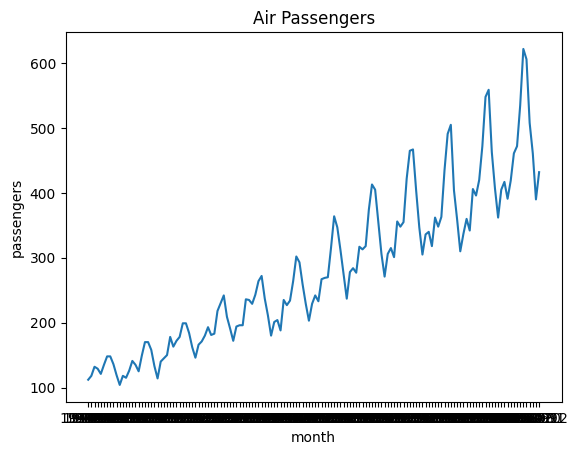

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

plt.plot(month, passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.title('Air Passengers')
plt.show()

## Clean trend and seasonality from data

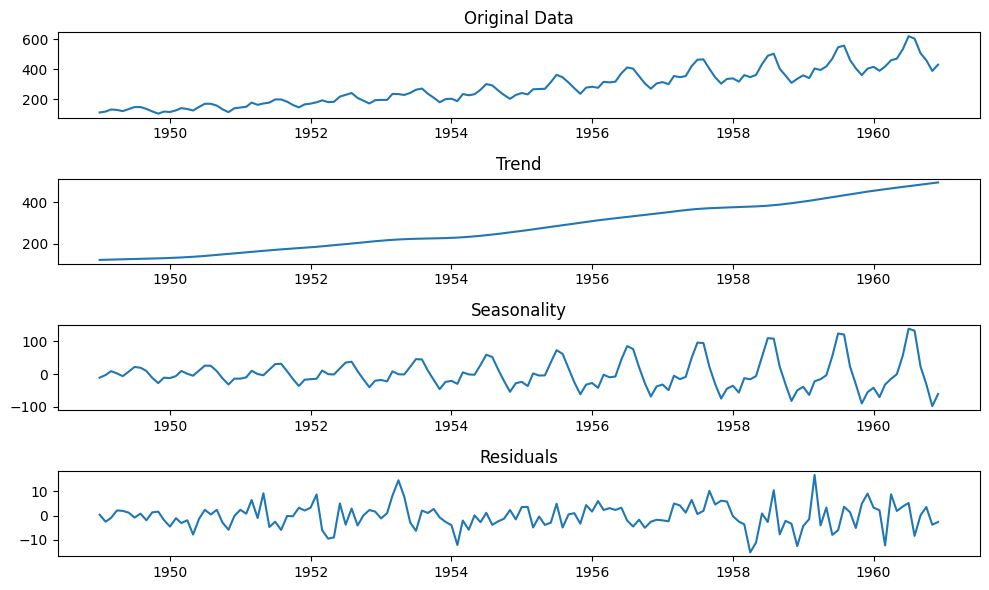

In [7]:
from statsmodels.tsa.seasonal import STL

# Assuming your data has a datetime column, set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Perform seasonal decomposition
decomp = STL(data).fit()

# Obtain the trend, seasonal, and residual components
trend = decomp.trend
seasonal = decomp.seasonal
residuals = decomp.resid

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 6))

plt.subplot(4, 1, 1)
plt.plot(data)
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(residuals)
plt.title('Residuals')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [8]:
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd

# Fetch Data
data = pd.read_csv('air_passengers.csv')

residuals_df = pd.DataFrame({'residuals': decomp.resid})
#residuals_df = residuals_df.round().astype(int)
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
data = data.dropna()
residuals_df = residuals_df.dropna()

data = data.drop('Passengers', axis=1)
#residuals_df['residuals'] = residuals_df['residuals'].astype(str)
residuals_df = residuals_df.drop(residuals_df.tail(2).index)
print(len(data))
print(len(residuals_df))

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

print(data.index)
print(residuals_df.index)



#data['residuals'] = pd.DataFrame({'residuals': decomp.resid})
#print(len(data['residuals']))
# data['residue'] = residuals
# Drop the NaN values created by shifting
data['residuals'] = residuals_df['residuals']

data['Month'] = pd.to_datetime(data['Month'])



residuals_df

144
140
RangeIndex(start=0, stop=144, step=1)
RangeIndex(start=0, stop=140, step=1)


,residuals,t-1,t-2
0,-0.934435,-2.506484,0.388692
1,2.143853,-0.934435,-2.506484
2,1.956051,2.143853,-0.934435
3,1.218765,1.956051,2.143853
4,-0.801732,1.218765,1.956051
...,...,...,...
135,3.763704,1.918945,8.766614
136,5.198703,3.763704,1.918945
137,-8.327198,5.198703,3.763704
138,0.163900,-8.327198,5.198703


In [9]:
train_ratio = 0.55
validation_ratio = 0.15
test_ratio = 0.30

# train is now 70% of the entire data set
train_data, temp = np.split(residuals_df, [int(train_ratio*len(residuals_df))])

# temp is now 30% of the initial data set
# validation is now 15% of the initial data set
# test is now 15% of the initial data set
validation_data, test_data = np.split(temp, [int((1 - test_ratio)*len(temp))])


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score


X_train = train_data[['t-1', 't-2']]
y_train = train_data['residuals']

model = RandomForestRegressor(max_depth=5, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Train the model
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, random_state=0)

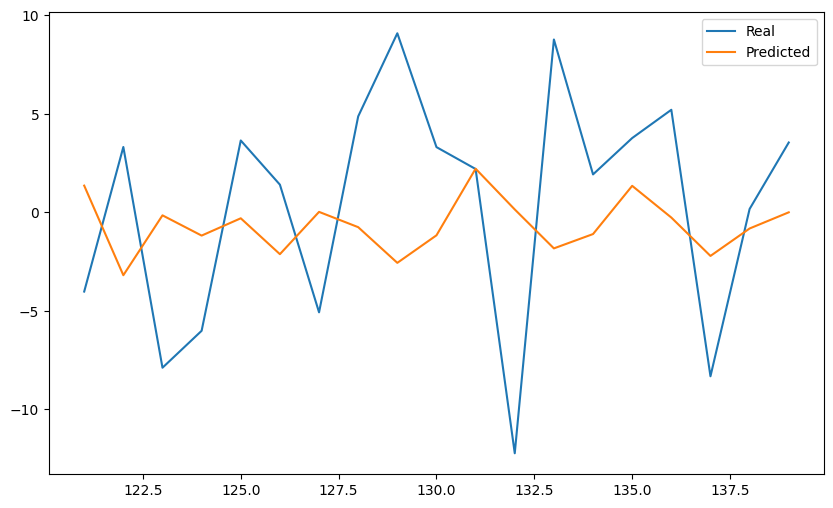

In [11]:
import matplotlib.pyplot as plt

X_test = test_data[['t-1', 't-2']]
y_test = test_data['residuals']

y_pred = model.predict(X_test)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error on test set:', mse)


Mean Squared Error on test set: 39.853216539938
